In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from datetime import datetime
import shap

In [2]:
exec(open("../../header.py").read())

# Import data

In [3]:
X = pd.read_csv(processed_root('cervical_cancer_risks/X.csv'))
y = pd.read_csv(processed_root('cervical_cancer_risks/y.csv'))

# Fit model

In [4]:
# fit RF
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X, y['Biopsy'])

RandomForestClassifier(n_estimators=500)

# Test classes

In [5]:
class SHAP_FI():
    
    def __init__(self, seed_num = None, time = True, trace = False, max_display = 999):
        '''
        Instantiates the SHAP_FI class.
        @param seed_num : Random seed for reproducibility.
        @param time: Set time functionality for runtime.
        @param trace : Turn on/off trace messages for debugging.
        @param max_display : Set max display of features.
        @return ICE data (dataframe) with N observations.
        @examples
        SHAP_FI(420, time = True, trace = False, max_display = 10)
        '''
        self.seed_num = seed_num
        self.trace = trace
        self.time = time
        self.max_display = max_display

        self.shapley = None
        
    def fit(self, X, model):
        '''
        Uses Shapley values to explain any machine learning model.
        @param X : Covariate matrix.
        @param model : Model to interpet.
        '''
        start = datetime.now()
        shap_values = shap.Explainer(model).shap_values(X)
        end = datetime.now()
        
        if self.time:
            print(f"Fit in {(end - start).total_seconds():.2f} seconds")
        
        self.shapley = shap_values
        
        return

    def plot(self, save_path = None):
        '''
        Plot the SHAP values.
        '''

        fig = shap.summary_plot(self.shapley[1], X, plot_type = "bar", max_display = self.max_display)
  
        
        if save_path is not None:
            fig.savefig(save_path,
                        bbox_inches = 'tight',
                        pad_inches = 1)
  

    def fi_table(self, X):
        '''
        Return SHAP Value table.
        '''
        
        features, vals = X.columns, np.abs(self.shapley[1]).mean(0)
        
        fi_df = pd.DataFrame(list(zip(features, vals)), columns=['Feature','Shapley Value']).\
               sort_values('Shapley Value', ascending = False).\
                head(self.max_display).\
                reset_index().\
                drop(['index'], axis=1)
    

        return fi_df  

In [21]:
def build_comparator_table(X, model, ice_object, fi_classes):
    '''
    Purpose: Build a table to compare our feature importance/impact metrics
    @X: Dataset with features as column names
    @model: Model we're analyzing
    @ice: ICE object
    @fi_classes: List of feature importance/impact class objects
        Each class should have standardized functions to fit and extract
        the feature importance/impact table
    '''
    
    
    output_table = ice_object.feature_impact_table()

    for fi in fi_classes:
        fi.fit(X, model)

        output_table = output_table.\
                merge(fi.fi_table(X), how = "left", on = "Feature")

    
    return output_table

# Shapley object

In [7]:
shapley = SHAP_FI()
shapley.fit(X, rf)

Fit in 22.44 seconds


# Age plot

In [22]:
exec(open("../../header.py").read())

In [23]:
ice = ICE("binary", trace = False)

In [24]:
ice.fit_single_feature(X, rf, "Age")

Fit Age in 2.07 seconds


Preprocessed data in 0.06 seconds
Plotted in 0.48 seconds


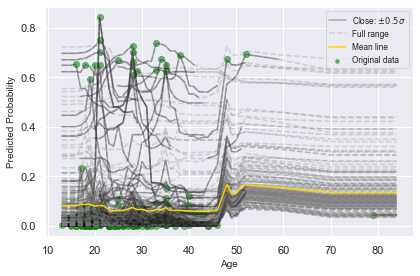

In [25]:
ice.ice_plot_single_feature('Age', plot_num = 200, mode = "ice", 
    save_path = results_root('cancer-dataset-production/age-ice.pdf'))

# Fit all

In [26]:
ice.fit(X, rf)

Fit Age in 1.82 seconds
Fit Number of sexual partners in 1.25 seconds
Fit First sexual intercourse in 1.76 seconds
Fit Num of pregnancies in 1.45 seconds
Fit Smokes in 1.27 seconds
Fit Smokes (years) in 2.34 seconds
Fit Smokes (packs/year) in 2.71 seconds
Fit Hormonal Contraceptives in 1.05 seconds
Fit Hormonal Contraceptives (years) in 2.18 seconds
Fit IUD in 1.48 seconds
Fit IUD (years) in 1.80 seconds
Fit STDs in 1.09 seconds
Fit STDs (number) in 1.13 seconds
Fit STDs:condylomatosis in 1.39 seconds
Fit STDs:cervical condylomatosis in 1.05 seconds
Fit STDs:vaginal condylomatosis in 1.19 seconds
Fit STDs:vulvo-perineal condylomatosis in 1.11 seconds
Fit STDs:syphilis in 1.41 seconds
Fit STDs:pelvic inflammatory disease in 1.33 seconds
Fit STDs:genital herpes in 1.06 seconds
Fit STDs:molluscum contagiosum in 1.20 seconds
Fit STDs:AIDS in 1.04 seconds
Fit STDs:HIV in 1.01 seconds
Fit STDs:Hepatitis B in 1.00 seconds
Fit STDs:HPV in 1.01 seconds
Fit STDs: Number of diagnosis in 1.03 seco

In [29]:
fi_classes = [shapley]

In [30]:
build_comparator_table(X, rf, ice, fi_classes)

Fit in 22.36 seconds


,Feature,Feature Impact,In-Dist Feature Impact,Normalized Feature Impact,Normalized In-Dist Feature Impact,Shapley Value
0,Age,0.146147,0.146090,1.300483,1.438337,0.013628
1,Number of sexual partners,0.100449,0.103884,0.893843,1.022795,0.011992
2,First sexual intercourse,0.873341,0.961431,7.771373,9.465794,0.012840
3,Num of pregnancies,0.079273,0.087525,0.705404,0.861727,0.014606
4,Smokes,0.023218,0.017529,0.206606,0.172582,0.002125
5,Smokes (years),0.113929,0.121375,1.013793,1.195005,0.003162
6,Smokes (packs/year),0.440285,0.461258,3.917849,4.541330,0.004945
7,Hormonal Contraceptives,0.018206,0.012783,0.162003,0.125857,0.008238
8,Hormonal Contraceptives (years),0.375961,0.398750,3.345468,3.925909,0.020072
9,IUD,0.061520,0.049290,0.547430,0.485284,0.003549
